### WGAN

* Модифицируйте код ячеек ниже и реализуйте [Wasserstein GAN](https://arxiv.org/abs/1701.07875) с клиппингом весов. (10 баллов)

* Замените клиппинг весов на [штраф градентов](https://arxiv.org/pdf/1704.00028v3.pdf). (10 баллов)

* Добавьте лейблы в WGAN, тем самым решая задачу [условной генерации](https://arxiv.org/pdf/1411.1784.pdf). (30 баллов)

Добавьте в этот файл анализ полученных результатов с различными графиками обучения и визуализацию генерации. Сравните как работает клиппинг весов и штраф градиентов и попробуйте пронаблюдать какие недостатки имеет модель GAN.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
class Config:
    pass

CONFIG = Config()
CONFIG.mnist_path = None
CONFIG.batch_size = 16
CONFIG.num_workers = 3
CONFIG.num_epochs = 10
CONFIG.noise_size = 50
CONFIG.print_freq = 500
CONFIG.learning_rate = 0.0002

In [3]:
dataset = torchvision.datasets.FashionMNIST("fashion_mnist", train=True, transform=torchvision.transforms.ToTensor(), download=True)

In [4]:
dataloader = DataLoader(dataset, batch_size=CONFIG.batch_size, shuffle=True)
len(dataloader)

3750

In [5]:
image, label = next(iter(dataloader))
image.size()

torch.Size([16, 1, 28, 28])

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 784),
            nn.Tanh()
        )

    def forward(self, x):
        out = self.model(x)
        out = out.view(x.size(0), 1, 28, 28)
        return out


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        out = self.model(x)
        return out

In [7]:
GENERATOR = Generator()
DISCRIMINATOR = Discriminator()

In [8]:
GENERATOR

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=784, bias=True)
    (5): Tanh()
  )
)

In [9]:
DISCRIMINATOR

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [10]:
def compute_gp(netD, real_data, fake_data):
        batch_size = real_data.size(0)
        # Sample Epsilon from uniform distribution
        eps = torch.rand(batch_size, 1, 1, 1).to(real_data.device)
        eps = eps.expand_as(real_data)
        
        # Interpolation between real data and fake data.
        interpolation = eps * real_data + (1 - eps) * fake_data
        
        # get logits for interpolated images
        interp_logits = netD(interpolation)
        grad_outputs = torch.ones_like(interp_logits)
        
        # Compute Gradients
        gradients = autograd.grad(
            outputs=interp_logits,
            inputs=interpolation,
            grad_outputs=grad_outputs,
            create_graph=True,
            retain_graph=True,
        )[0]
        
        # Compute and return Gradient Norm
        gradients = gradients.view(batch_size, -1)
        grad_norm = gradients.norm(2, 1)
        return torch.mean((grad_norm - 1) ** 2)

In [11]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cuda


In [12]:
def train(generator, discriminator, dataloader, num_epochs, lr, device):
    discriminator.to(device)
    generator.to(device)

    criterion = nn.BCEWithLogitsLoss()

    d_optimizer = optim.Adam(discriminator.parameters(), lr=lr)
    g_optimizer = optim.Adam(generator.parameters(), lr=lr)

    for epoch in range(num_epochs):
        for i, (real_images, _) in enumerate(dataloader):
            real_images = real_images.to(device)
            batch_size = real_images.size(0)
            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            # Train the discriminator
            discriminator.zero_grad()
            real_outputs = discriminator(real_images)
            d_loss_real = criterion(real_outputs, real_labels)

            z = torch.randn(batch_size, 100).to(device)
            fake_images = generator(z)
            fake_outputs = discriminator(fake_images.detach())
            d_loss_fake = criterion(fake_outputs, fake_labels)

            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            d_optimizer.step()

            # Train the generator
            generator.zero_grad()
            z = torch.randn(batch_size, 100).to(device)
            fake_images = generator(z)
            fake_outputs = discriminator(fake_images)
            g_loss = criterion(fake_outputs, real_labels)

            g_loss.backward()
            g_optimizer.step()

            if (i+1) % 200 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}")

In [14]:
torch.manual_seed(42)

In [13]:
train(GENERATOR, DISCRIMINATOR, dataloader, num_epochs=CONFIG.num_epochs, lr=CONFIG.learning_rate, device=DEVICE)

Epoch [1/10], Step [200/3750], d_loss: 0.1215, g_loss: 4.8703
Epoch [1/10], Step [400/3750], d_loss: 0.1345, g_loss: 4.0497
Epoch [1/10], Step [600/3750], d_loss: 1.3821, g_loss: 2.4571
Epoch [1/10], Step [800/3750], d_loss: 0.5605, g_loss: 3.5286
Epoch [1/10], Step [1000/3750], d_loss: 1.2953, g_loss: 1.4306
Epoch [1/10], Step [1200/3750], d_loss: 0.9752, g_loss: 1.2572
Epoch [1/10], Step [1400/3750], d_loss: 0.7945, g_loss: 1.1537
Epoch [1/10], Step [1600/3750], d_loss: 1.0478, g_loss: 1.8681
Epoch [1/10], Step [1800/3750], d_loss: 0.7407, g_loss: 2.9320
Epoch [1/10], Step [2000/3750], d_loss: 0.4573, g_loss: 2.2434
Epoch [1/10], Step [2200/3750], d_loss: 0.5185, g_loss: 2.3154
Epoch [1/10], Step [2400/3750], d_loss: 0.7809, g_loss: 2.1655
Epoch [1/10], Step [2600/3750], d_loss: 0.7216, g_loss: 2.6294
Epoch [1/10], Step [2800/3750], d_loss: 0.9542, g_loss: 3.1566
Epoch [1/10], Step [3000/3750], d_loss: 0.8104, g_loss: 1.9495
Epoch [1/10], Step [3200/3750], d_loss: 0.5221, g_loss: 3.2

Epoch [8/10], Step [1200/3750], d_loss: 0.7260, g_loss: 1.3891
Epoch [8/10], Step [1400/3750], d_loss: 0.5337, g_loss: 1.9016
Epoch [8/10], Step [1600/3750], d_loss: 1.0785, g_loss: 1.5497
Epoch [8/10], Step [1800/3750], d_loss: 0.8374, g_loss: 1.7873
Epoch [8/10], Step [2000/3750], d_loss: 0.8118, g_loss: 1.7545
Epoch [8/10], Step [2200/3750], d_loss: 0.8107, g_loss: 1.4676
Epoch [8/10], Step [2400/3750], d_loss: 0.7392, g_loss: 1.6004
Epoch [8/10], Step [2600/3750], d_loss: 0.9842, g_loss: 1.3384
Epoch [8/10], Step [2800/3750], d_loss: 0.7631, g_loss: 1.5791
Epoch [8/10], Step [3000/3750], d_loss: 0.8413, g_loss: 2.1133
Epoch [8/10], Step [3200/3750], d_loss: 0.6437, g_loss: 1.6684
Epoch [8/10], Step [3400/3750], d_loss: 1.0842, g_loss: 1.6060
Epoch [8/10], Step [3600/3750], d_loss: 0.7595, g_loss: 1.4101
Epoch [9/10], Step [200/3750], d_loss: 0.7933, g_loss: 1.1584
Epoch [9/10], Step [400/3750], d_loss: 0.6680, g_loss: 1.3302
Epoch [9/10], Step [600/3750], d_loss: 0.8418, g_loss: 1.

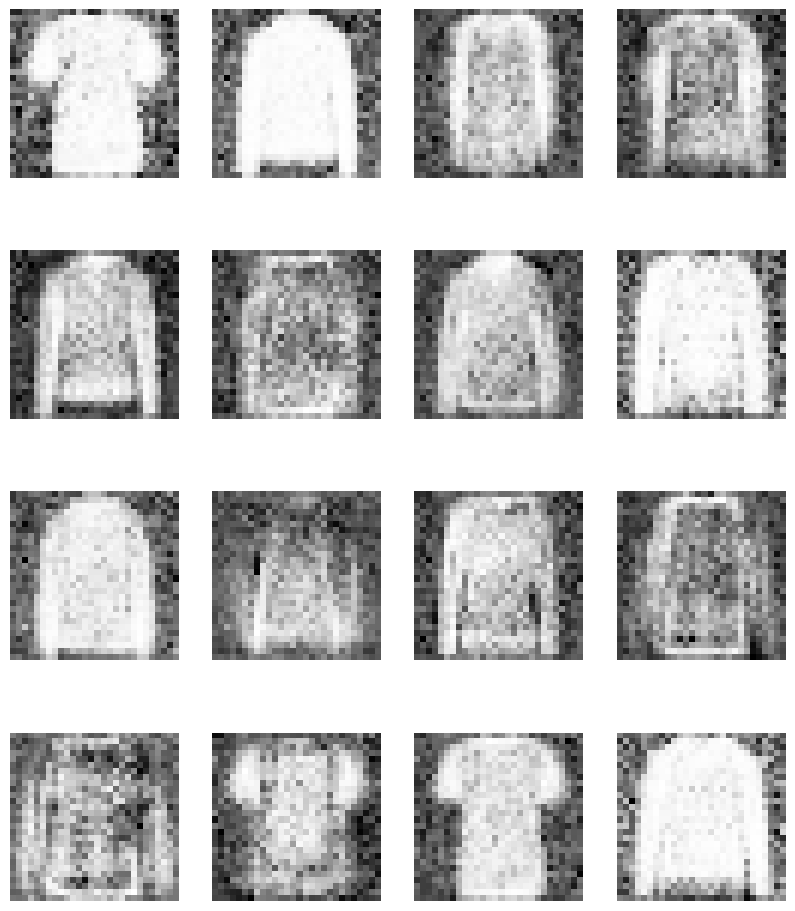

In [14]:
IMG_QTY = 16
IMG_SIZE = int(math.sqrt(IMG_QTY))

noise = torch.randn(IMG_QTY, 100, device=DEVICE)  # Generate 10 random noise vectors
generated_images = GENERATOR(noise)  # Generate images using the generator

plt.figure(figsize=(10, 12))
for i in range(IMG_QTY):
    plt.subplot(IMG_SIZE, IMG_SIZE, i+1)
    plt.imshow(generated_images[i].cpu().detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis("off")